# DIP

## Import libs

In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline

import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '3'

import numpy as np
from models import *

import torch
import torch.optim

from skimage.metrics import peak_signal_noise_ratio, structural_similarity 
from utils import *

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor

imsize =-1
PLOT = True
sigma = 25
sigma_ = sigma/255.

torch.cuda.is_available()

True

## Load image

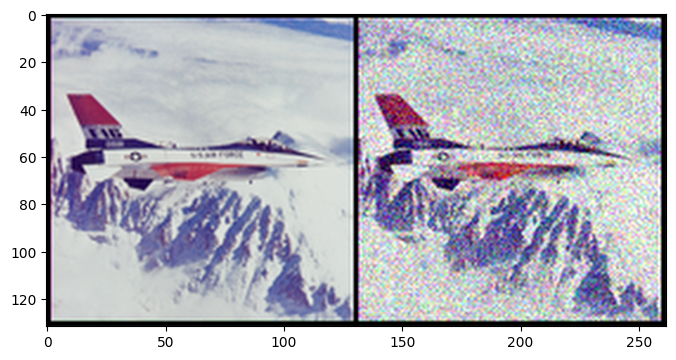

array([[[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.69803923, ..., 0.7378155 ,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.6666667 , ..., 0.58582526,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]],

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.6117647 , ..., 0.6978018 ,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.6392157 , ..., 0.6076416 ,
         0.        , 0.        ],
        [0. 

In [2]:
fname = 'data/denoising/F16_GT.png'

# Add synthetic noise
img_pil = crop_image(get_image(fname, imsize)[0], d=32)

# resize to 128 128
img_pil = img_pil.resize((128,128))
img_np = pil_to_np(img_pil)
    
img_noisy_pil, img_noisy_np = get_noisy_image(img_np, sigma_)
    
plot_image_grid([img_np, img_noisy_np], 4, 6)

## Setup

In [3]:
INPUT = 'noise' # 'meshgrid'
pad = 'reflection'
OPT_OVER = 'net' # 'net,input'

reg_noise_std = 1./30. # set to 1./20. for sigma=50
LR = 0.01

OPTIMIZER='adam' # 'LBFGS'
show_every = 500
exp_weight= 0.99

num_iter = 1000
input_depth = 32 
figsize = 4 
    
    
net = get_net(input_depth, 'skip', pad,
                  skip_n33d=128, 
                  skip_n33u=128, 
                  skip_n11=4, 
                  num_scales=5,
                  upsample_mode='bilinear').type(dtype)

net_input = get_noise(input_depth, INPUT, (img_pil.size[1], img_pil.size[0])).type(dtype).detach()

# Compute number of parameters
s  = sum([np.prod(list(p.size())) for p in net.parameters()]); 
print ('Number of params: %d' % s)

# Loss
mse = torch.nn.MSELoss().type(dtype)

img_noisy_torch = np_to_torch(img_noisy_np).type(dtype)

Number of params: 2217831


## Optimize

Starting optimization with ADAM


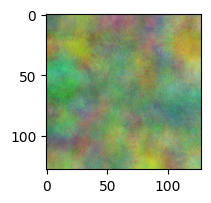

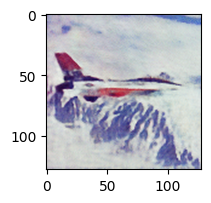

In [4]:
net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()
last_net = None
psrn_noisy_last = 0

i = 0
def closure():
    
    global i, psrn_noisy_last, last_net, net_input
    
    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)
    
    out = net(net_input)
    

    total_loss = mse(out, img_noisy_torch)
    total_loss.backward()
        
    
    psrn_noisy = peak_signal_noise_ratio(img_noisy_np, out.detach().cpu().numpy()[0]) 
    psrn_gt    = peak_signal_noise_ratio(img_np, out.detach().cpu().numpy()[0]) 
    ssim = structural_similarity(img_np, out.detach().cpu().numpy()[0], win_size=7,channel_axis=0, data_range=1.0, multichannel=True)

    # Note that we do not have GT for the "snail" example
    # So 'PSRN_gt', 'PSNR_gt_sm' make no sense
    print ('Iteration %05d    Loss %f   PSNR: %f   SSIM: %f' % (i, total_loss.item(), psrn_gt, ssim), '\r', end='')
    if  PLOT and i % show_every == 0:
        out_np = torch_to_np(out)
        plot_image_grid([np.clip(out_np, 0, 1)])
        
        
    
    # Backtracking
    if i % show_every:
        if psrn_noisy - psrn_noisy_last < -5: 
            print('Falling back to previous checkpoint.')

            for new_param, net_param in zip(last_net, net.parameters()):
                net_param.data.copy_(new_param.cuda())

            return total_loss*0
        else:
            last_net = [x.detach().cpu() for x in net.parameters()]
            psrn_noisy_last = psrn_noisy
            
    i += 1

    return total_loss

p = get_params(OPT_OVER, net, net_input)
optimize(OPTIMIZER, p, closure, LR, num_iter)

## Prior

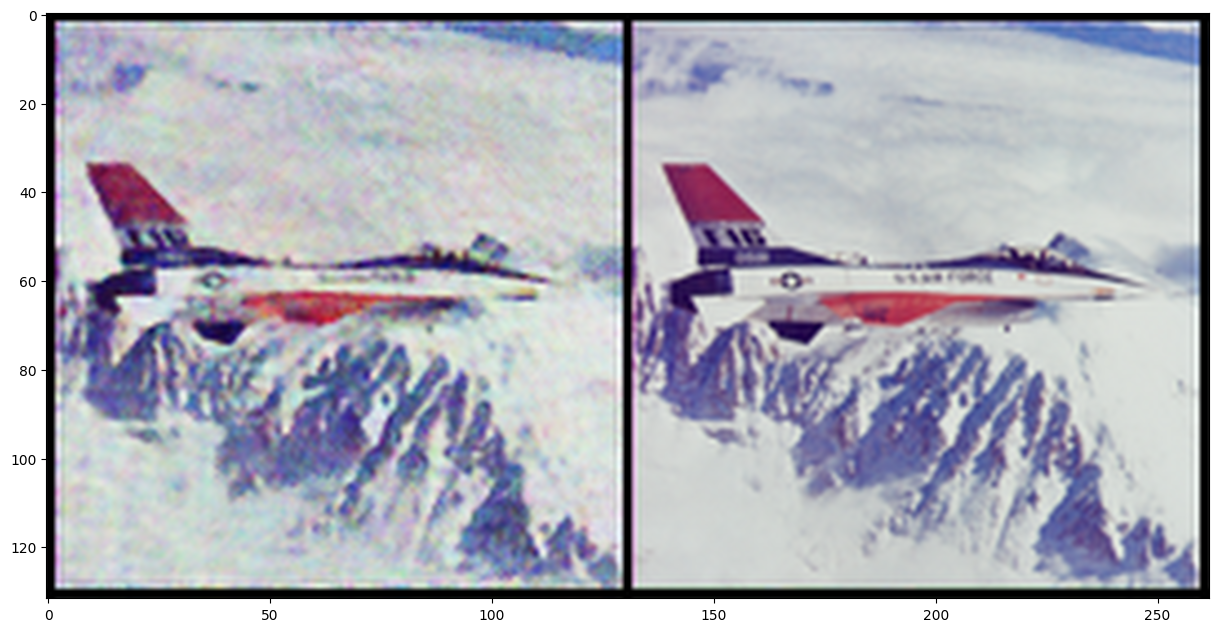

In [5]:
if num_iter == 0:
    out_np = img_noisy_np
else:
    out_np = torch_to_np(net(net_input))
q = plot_image_grid([np.clip(out_np, 0, 1), img_np], factor=13)

plt.imsave(f'denoising{num_iter}.png', np.clip(out_np, 0, 1).transpose(1, 2, 0))

# DDPM

## import libraries


In [6]:
import torch
from torchvision import transforms
from PIL import Image
from denoising_diffusion_pytorch import Unet, GaussianDiffusion
import os
from IPython.display import display

c:\Users\jerem\anaconda3\envs\py311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Setup


In [7]:
# Check if GPU is available

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('Using device:', device)

# Load the Lena image from the data folder
data_dir = "./"
file_name = "denoising.png"
img_path = os.path.join(data_dir, file_name)
img = Image.open(img_path).convert("RGB")

# Preprocess the image
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

img_tensor = transform(img).unsqueeze(0).to(device)  # Add batch dimension
img_tensor = img_tensor * 2 - 1  # Normalize to [-1, 1]

# Initialize the model
model = Unet(
    dim=64,
    dim_mults=(1, 2, 4, 8),
    flash_attn=True
).to(device)

diffusion = GaussianDiffusion(
    model,
    image_size=128,
    timesteps=1000    # number of steps
).to(device)

# Define the training loop
optimizer = torch.optim.Adam(diffusion.parameters(), lr=1e-4)
num_epochs = 15000

Using device: cuda
Non-A100 GPU detected, using math or mem efficient attention if input tensor is on cuda


## training loop

In [8]:
losses = []
psnrs = []
ssims = []

c:\Users\jerem\anaconda3\envs\py311\Lib\site-packages\denoising_diffusion_pytorch\attend.py:86: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  out = F.scaled_dot_product_attention(
sampling loop time step: 100%|██████████| 1000/1000 [00:29<00:00, 33.73it/s]

Epoch 500/15000, Loss: 0.036463089287281036, PSNR: 13.8368952219758, SSIM: 0.11602584272623062


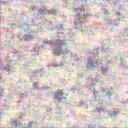

sampling loop time step:  82%|████████▏ | 819/1000 [00:19<00:04, 43.66it/s]

In [9]:
for epoch in range(num_epochs):
    optimizer.zero_grad()
    loss = diffusion(img_tensor)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 500 == 0:
        # Sample images
        sampled_images = diffusion.sample(batch_size=1)
        
        # Ensure the sampled images have the correct shape
        sampled_images = sampled_images.cpu().detach()
        sampled_image = sampled_images[0]  # Remove batch dimension

        # Denormalize the image from [-1, 1] to [0, 1]
        sampled_image = (sampled_image + 1) / 2
        sampled_image = sampled_image.clamp(0, 1)
        
        # calculate PSNR_noisy PSRN_gt
        psnr = peak_signal_noise_ratio(img_np, sampled_image.cpu().detach().numpy())

        # calculate ssim
        ssim = structural_similarity(img_np, sampled_image.cpu().detach().numpy(), win_size=7,channel_axis=0, data_range=1.0, multichannel=True)

        
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}, PSNR: {psnr}, SSIM: {ssim}")
        losses.append(loss.item())
        psnrs.append(psnr)
        ssims.append(ssim)

        # Convert to PIL Image
        sampled_image_pil = transforms.ToPILImage()(sampled_image)
        display(sampled_image_pil)
        
        # torch.save(diffusion.state_dict(), f"diffusion_model_epoch_{epoch + 1}.pth")
        # sampled_image_pil.save(f"sampled_image_epoch_{epoch + 1}.png")



